# Conditional GAN with MNIST

* MNIST data를 가지고 **Conditional GAN**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)
* based on dcgan

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

#tf.set_random_seed(219)
#np.random.seed(219)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="2"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Training Flags (hyperparameter configuration)
train_dir = 'train/cgan_based_on_dcgan/exp1/'
max_epochs = 20 * 2 # effectively 30 epoch due to twice call the same data
#max_epochs = 20
save_epochs = 10
summary_steps = 2500
print_steps = 1000
batch_size = 64
learning_rate_D = 0.0002
learning_rate_G = 0.001
k = 1 # the number of step of learning D before learning G
num_samples = 10 # the number of class on MNIST

## Import MNIST

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), _ = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data
train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int)
train_labels = train_labels

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=max_epochs)
#train_dataset = train_dataset.batch(batch_size = batch_size)
train_dataset = train_dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
print(train_dataset)

<_RestructuredDataset shapes: ((64, 28, 28), (64,)), types: (tf.float64, tf.int64)>


## Create the model

In [5]:
class CGAN(object):
  """Conditional Generative Adversarial Networks
  implementation based on http://arxiv.org/abs/1411.1784
  
  "Conditional Generative Adversarial Nets"
  Mehdi Mirza, Simon Osindero
  """
  
  def __init__(self, mode, train_dataset, test_dataset=None):
    """Basic setup.
    
    Args:
      mode (`string`): "train" or "generate".
      train_dataset (`tf.data.Dataset`): train_dataset.
      test_dataset (`tf.data.Dataset`): test_dataset.
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 28
    self.z_dim = 100
    self.y_dim = 10 # for number of class on MNIST
    self.batch_size = batch_size
    self.num_samples = num_samples
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_random_z_inputs(self):
    """Build a vector random_z in latent space.
    
    Returns:
      self.random_z (`4-rank Tensor` with [batch_size, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
      self.sample_random_z (`4-rank Tensor` with [num_samples, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
    """
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      self.random_z = tf.random_uniform([self.batch_size, 1, 1, self.z_dim],
                                        minval=-1.0, maxval=1.0)
      self.sample_random_z = tf.random_uniform([self.num_samples, 1, 1, self.z_dim],
                                               minval=-1.0, maxval=1.0)

    return self.random_z, self.sample_random_z
  
  
  def read_MNIST(self, dataset):
    """Read MNIST dataset and create a conditional vector c.
    
    Args:
      dataset (`tf.data.Dataset` format): MNIST dataset.
      
    Returns:
      self.mnist (`4-rank Tensor` with [batch, x_dim, x_dim, 1]): MNIST dataset with batch size.
      self.condition (`4-rank Tensor` with [batch, 1, 1, y_dim]): MNIST lable dataset with batch size.
    """
    with tf.variable_scope('mnist'):
      iterator = dataset.make_one_shot_iterator()

      self.mnist, self.condition = iterator.get_next()
      self.mnist = tf.cast(self.mnist, dtype = tf.float32)
      self.mnist = tf.expand_dims(self.mnist, axis=3)
      self.condition = tf.one_hot(self.condition, depth=self.y_dim)
      self.condition = tf.reshape(self.condition, shape=[-1, 1, 1, self.y_dim])
      self.condition = tf.cast(self.condition, dtype = tf.float32)
      
    return self.mnist, self.condition


  def Generator(self, random_z, condition, is_training=True, reuse=False):
    """Generator setup.
    
    Args:
      random_z (`4-rank Tensor` with [batch_size, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
      condition (`4-rank Tensor` with [batch_size, 1, 1, y_dim]):
          conditional vector which size is the number of class on MNIST.
      is_training (`bool`): whether training mode or test mode.
      reuse (`bool`): whether variable reuse or not.
      
    Returns:
      generated_data (`4-rank Tensor` with [batch_size, h, w, c])
          generated images from random vector z.
    """
    with tf.variable_scope('Generator', reuse=reuse) as scope:
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'is_training': is_training,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):

        # Use full conv2d_transpose instead of projection and reshape
        # random_z: 100 dim
        self.inputs = tf.concat([random_z, condition], axis=3)
        # inputs = 1 x 1 x 100 dim
        self.layer1 = slim.conv2d_transpose(inputs=self.inputs,
                                            num_outputs=256,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer1')
        # layer1: 3 x 3 x 256 dim
        self.layer2 = slim.conv2d_transpose(inputs=self.layer1,
                                            num_outputs=128,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer2')
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d_transpose(inputs=self.layer2,
                                            num_outputs=64,
                                            scope='layer3')
        # layer3: 14 x 14 x 64 dim
        self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                            num_outputs=1,
                                            normalizer_fn=None,
                                            activation_fn=tf.sigmoid,
                                            scope='layer4')
        # output = layer4: 28 x 28 x 1 dim
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, condition, reuse=False):
    """Discriminator setup.
    
    Args:
      data (`4-rank Tensor` with [batch_size, x_dim, x_dim, 1]): MNIST real data.
      condition (`4-rank Tensor` with [batch_size, 1, 1, y_dim]):
          conditional vector which size is the number of class on MNIST.
      reuse (`bool`): whether variable reuse or not.
      
    Returns:
      logits (`1-rank Tensor` with [batch_size]): logits of data.
    """
    with tf.variable_scope('Discriminator', reuse=reuse) as scope:
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):

        # data: 28 x 28 x 1 dim
        # condition: 10 dim (for MNIST)
        self.inputs = tf.concat([data,
                                 condition * tf.ones([self.batch_size,
                                                      self.x_dim, self.x_dim,
                                                      self.y_dim])], axis=3)
        
        # inputs: 28 x 28 x (1 + 10) dim
        self.layer1 = slim.conv2d(inputs=self.inputs,
                                  num_outputs=64,
                                  normalizer_fn=None,
                                  scope='layer1')
        # layer1: 14 x 14 x 64 dim
        self.layer2 = slim.conv2d(inputs=self.layer1,
                                  num_outputs=128,
                                  scope='layer2')
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d(inputs=self.layer2,
                                  num_outputs=256,
                                  kernel_size=[3, 3],
                                  padding='VALID',
                                  scope='layer3')
        # layer3: 3 x 3 x 256 dim
        self.layer4 = slim.conv2d(inputs=self.layer3,
                                  num_outputs=1,
                                  kernel_size=[3, 3],
                                  stride=[1, 1],
                                  padding='VALID',
                                  normalizer_fn=None,
                                  activation_fn=None,
                                  scope='layer4')
        # logits = layer4: 1 x 1 x 1 dim
        discriminator_logits = tf.squeeze(self.layer4, axis=[1, 2])

        return discriminator_logits
    
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      self.global_step = tf.train.get_or_create_global_step()
      
      print('complete setup global_step.')
      
      
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits (`1-rank Tensor`): logits.
      is_real (`bool`): True means `1` labeling, False means `0` labeling.
      
    Returns:
      loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z, self.sample_random_z = self.build_random_z_inputs()
      # read dataset and create conditional vector
      self.real_data, self.condition = self.read_MNIST(self.train_dataset)
      
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z, self.condition)
      
      # discriminating real data by Discriminator()
      self.real_logits = self.Discriminator(self.real_data, self.condition)
      # discriminating fake data (generated)_images) by Discriminator()
      self.fake_logits = self.Discriminator(self.generated_data, self.condition, reuse=True)
      
      # losses of real with label "1"
      self.loss_real = self.GANLoss(logits=self.real_logits, is_real=True, scope='loss_D_real')
      # losses of fake with label "0"
      self.loss_fake = self.GANLoss(logits=self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # losses of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
      # losses of Generator with label "1" that used to fool the Discriminator
      self.loss_Generator = self.GANLoss(logits=self.fake_logits, is_real=True, scope='loss_G')
      
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      
      
      # generating images for sample
      self.sample_condition = tf.eye(self.y_dim)
      self.sample_condition = tf.reshape(self.sample_condition, [-1, 1, 1, self.y_dim])
      self.sample_data = self.Generator(self.sample_random_z, self.sample_condition, is_training=False, reuse=True)
      
      # write summaries
      # Add loss summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      
      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
      
      # Add image summaries
      tf.summary.image('random_images', self.generated_data, max_outputs=4)
      tf.summary.image('real_images', self.real_data)
      
    print('complete model build.\n')

## Define plot function

In [6]:
def print_sample_data(sample_data, max_print=num_samples):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

## Build a model

In [7]:
model = CGAN(mode="train", train_dataset=train_dataset)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 3x3x256x110) [253440, bytes: 1013760]
Generator/layer1/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
Generator/layer2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Generator/layer4/biases:0 (float32_ref 1) [1, bytes: 4]
Discriminator/layer1/weights:0 (float32_ref 4x4x11x64) [11264, bytes: 45056]
Discriminator/layer1/biases:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_ref 12

(1120898, 4483592)

In [8]:
opt_D = tf.train.AdamOptimizer(learning_rate=learning_rate_D, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=learning_rate_G, beta1=0.5)

In [9]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
  opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
  opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)

### Assign `tf.summary.FileWriter`

In [10]:
graph_location = train_dir
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: train/cgan_based_on_dcgan/exp1/


### `tf.summary`

In [11]:
summary_op = tf.summary.merge_all()

### `tf.train.Saver`

In [12]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

### `tf.Session` and train

INFO:tensorflow:Start Session.
Epochs: 0.00 global_step: 0 loss_D: 1.643 loss_G: 0.868 (36.48 examples/sec; 1.754 sec/batch)


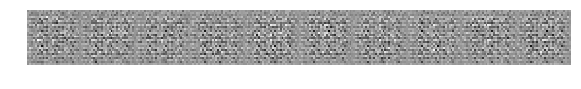

Epochs: 1.07 global_step: 1000 loss_D: 1.491 loss_G: 0.866 (6775.76 examples/sec; 0.009 sec/batch)


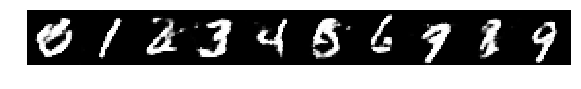

Epochs: 2.13 global_step: 2000 loss_D: 1.365 loss_G: 0.766 (6743.42 examples/sec; 0.009 sec/batch)


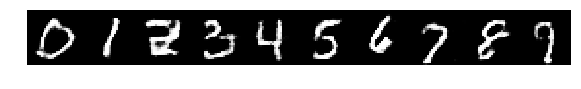

Epochs: 3.20 global_step: 3000 loss_D: 1.436 loss_G: 0.728 (6706.02 examples/sec; 0.010 sec/batch)


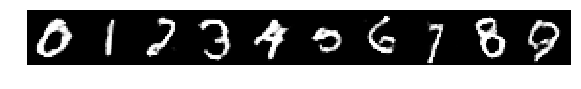

Epochs: 4.27 global_step: 4000 loss_D: 1.417 loss_G: 0.759 (6418.83 examples/sec; 0.010 sec/batch)


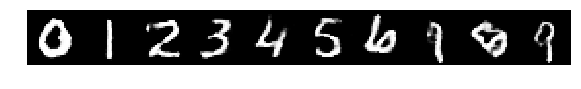

Epochs: 5.33 global_step: 5000 loss_D: 1.411 loss_G: 0.730 (6664.73 examples/sec; 0.010 sec/batch)


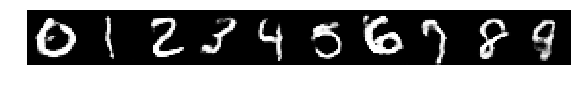

Epochs: 6.40 global_step: 6000 loss_D: 1.416 loss_G: 0.711 (6271.71 examples/sec; 0.010 sec/batch)


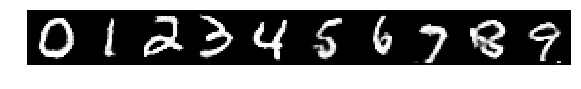

Epochs: 7.47 global_step: 7000 loss_D: 1.370 loss_G: 0.735 (6557.60 examples/sec; 0.010 sec/batch)


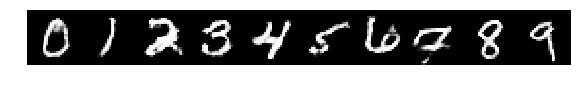

Epochs: 8.53 global_step: 8000 loss_D: 1.353 loss_G: 0.674 (6494.30 examples/sec; 0.010 sec/batch)


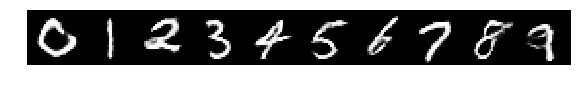

Epochs: 9.60 global_step: 9000 loss_D: 1.356 loss_G: 0.704 (6385.09 examples/sec; 0.010 sec/batch)


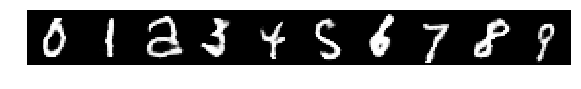

INFO:tensorflow:Saving model with global step 9375 (= 10 epochs) to disk.
Epochs: 10.67 global_step: 10000 loss_D: 1.388 loss_G: 0.674 (6561.45 examples/sec; 0.010 sec/batch)


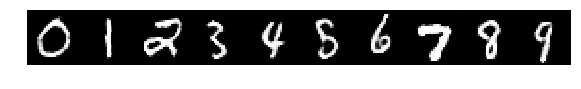

Epochs: 11.73 global_step: 11000 loss_D: 1.384 loss_G: 0.699 (6450.91 examples/sec; 0.010 sec/batch)


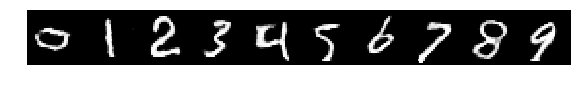

Epochs: 12.80 global_step: 12000 loss_D: 1.401 loss_G: 0.669 (6418.06 examples/sec; 0.010 sec/batch)


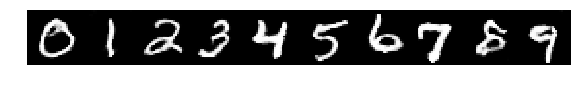

Epochs: 13.87 global_step: 13000 loss_D: 1.347 loss_G: 0.652 (6439.77 examples/sec; 0.010 sec/batch)


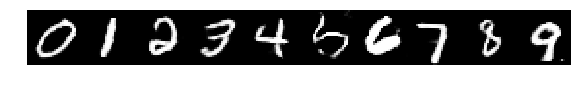

Epochs: 14.93 global_step: 14000 loss_D: 1.350 loss_G: 0.675 (7033.37 examples/sec; 0.009 sec/batch)


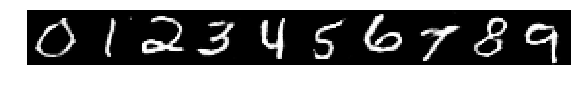

Epochs: 16.00 global_step: 15000 loss_D: 1.418 loss_G: 0.714 (6625.75 examples/sec; 0.010 sec/batch)


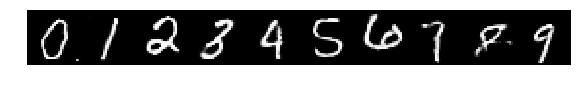

Epochs: 17.07 global_step: 16000 loss_D: 1.375 loss_G: 0.690 (6176.75 examples/sec; 0.010 sec/batch)


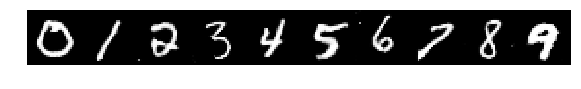

Epochs: 18.13 global_step: 17000 loss_D: 1.342 loss_G: 0.727 (6414.53 examples/sec; 0.010 sec/batch)


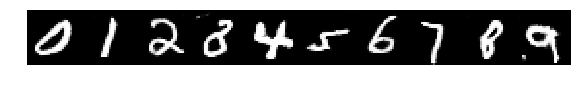

Epochs: 19.20 global_step: 18000 loss_D: 1.304 loss_G: 0.736 (6377.81 examples/sec; 0.010 sec/batch)


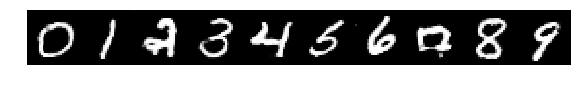

End of dataset
INFO:tensorflow:Saving model with global step 18745 (= 19 epochs) to disk.
INFO:tensorflow:complete training...


In [13]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  tf.logging.info('Start Session.')
  
  num_examples = len(train_data)
  num_batches_per_epoch = int(num_examples / batch_size)
  
  # save loss values for plot
  loss_history = []
  pre_epochs = 0
  while True:
    try:
      start_time = time.time()
      
      for _ in range(k):
        _, loss_D = sess.run([opt_D_op, model.loss_Discriminator])
      _, global_step_, loss_G = sess.run([opt_G_op,
                                          model.global_step,
                                          model.loss_Generator])
      
      epochs = global_step_ * batch_size / float(num_examples)
      duration = time.time() - start_time

      if global_step_ % print_steps == 0:
        examples_per_sec = batch_size / float(duration)
        print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                  epochs, global_step_, loss_D, loss_G, examples_per_sec, duration))

        loss_history.append([epochs, loss_D, loss_G])

        # print sample data
        sample_data = sess.run(model.sample_data)
        print_sample_data(sample_data)

      # write summaries periodically
      if global_step_ % summary_steps == 0:
        summary_str = sess.run(summary_op)
        train_writer.add_summary(summary_str, global_step=global_step_)

      # save model checkpoint periodically
      if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
        tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
        saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
        pre_epochs = int(epochs)
        
    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
      break
      
  tf.logging.info('complete training...')

## Plot loss functions

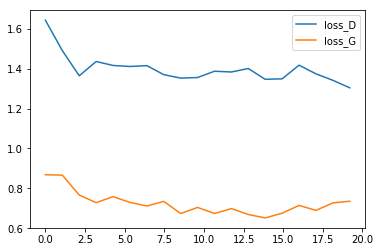

In [14]:
loss_history = np.asarray(loss_history)

plt.plot(loss_history[:,0], loss_history[:,1], label='loss_D')
plt.plot(loss_history[:,0], loss_history[:,2], label='loss_G')
plt.legend(loc='upper right')
plt.show()